In [3]:

#!pip install numpy==1.23.4
#!pip install git+https://github.com/lnccbrown/hssm@main
#!pip install git+https://github.com/brown-ccv/hddm-wfpt@main
#!pip install numpyro


In [4]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Adjust display options
#pd.set_option('display.max_rows', 600)  # Display all rows
#pd.set_option('display.max_columns', None)  # Display all columns
#pd.set_option('display.width', None)  # Allow unlimited width for display

# Initialize empty list 
dfs = []
participant_ids = []

# Iterate through each CSV file in the folder
pathlist = Path("data/").rglob('*.csv')
for participant_id, path in enumerate(pathlist, start=1):
    df = pd.read_csv(path)
    dfs.append(df)
    participant_ids.extend([participant_id] * len(df))

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['participant_id'] = participant_ids
#print(combined_df)

# Reorder columns to place participant ID column first
cols = combined_df.columns.tolist()
cols = ['participant_id'] + [col for col in cols if col != 'participant_id']
combined_df = combined_df[cols]

# Clean data
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df.rt != -1]

true_false_lst_mov = []
true_false_lst_or = []

# Iterate through each task type
for task_type in combined_df['task_type'].unique():
    # Filter the DataFrame for the current task type
    task_data = combined_df[combined_df['task_type'] == task_type]
    
    # Iterate through each participant
    for i in range(1, max(task_data['participant_id']) + 1):
        # Filter the DataFrame for the current participant and task type
        participant_data = task_data[(task_data['participant_id'] == i)]
        
        # Count the True and False answers for the current participant
        true_count = participant_data['correct'].eq(True).sum()
        false_count = participant_data['correct'].eq(False).sum()
        total_count = true_count + false_count
        
        # Calculate ratio
        if total_count > 0:
            ratio_count = true_count / total_count
        else:
            ratio_count = 0.0
        
        # Create a dictionary with the counts for the current participant and task type
        bool_dict = {
            "Participant": i,
            "Task_Type": task_type,
            "True": true_count,
            "False": false_count,
            "ratio": ratio_count
        }
        
        # Append the dictionary to respective list based on task type
        if task_type == 'mov':
            true_false_lst_mov.append(bool_dict)
        elif task_type == 'or':
            true_false_lst_or.append(bool_dict)


# Get the intersection of the two lists to find participants meeting both conditions
selected_ids_mov = [x['Participant'] for x in true_false_lst_mov if x['ratio'] >= 0.8]
selected_ids_or = [x['Participant'] for x in true_false_lst_or if x['ratio'] >= 0.8]
selected_ids = list(set(selected_ids_mov).intersection(selected_ids_or))

# Filter the combined_df based on the selected_participant_ids
filtered_df = combined_df[combined_df.participant_id.isin(selected_ids)]


# extra df for plots
df_repetition = filtered_df[filtered_df['task_transition'] == 'repetition']
df_switch = filtered_df[filtered_df['task_transition'] == 'switch']
df_or = filtered_df[filtered_df.task_type != "or"]
df_mov = filtered_df[filtered_df.task_type != "mov"]

# miliseconds to seconds
filtered_df = filtered_df.astype({'rt': 'float64'})
filtered_df.loc[:, 'rt'] = filtered_df['rt'] / 1000
filtered_df.loc[:, 'rt'] = filtered_df[filtered_df['rt'] <= 2]
#change parameter Into numeric
filtered_df['key_press'] = filtered_df['key_press'].map({'f': -1.0, 'j': 1.0})
filtered_df['correct'] = filtered_df['correct'].map({False: 0.0, True: 1.0})
filtered_df['task_type'] = filtered_df['task_type'].map({"or": 0.0, "mov": 1.0})
filtered_df['task_transition'] = filtered_df['task_transition'].map({"repetition": 0.0, "switch": 1.0})
filtered_df['congruency'] = filtered_df['congruency'].map({"congruent": 0.0, "incongruent": 1.0})
filtered_df = filtered_df.rename(columns={"key_press": "response"})
filtered_df = filtered_df.dropna()

filtered_df

#filtered_df['rt']


#combined_df
#for entry in true_false_lst_or:
#    print(entry)
#for entry in true_false_lst_mov:
#    print(entry)
#for entry in true_false_lst_or:
#    print(entry)
#selected_ids
#len(selected_ids)


,participant_id,rt,response,correct,coherent_movement_direction,coherent_orientation,task_type,task_transition,congruency
1,1,1.164,-1.0,1.0,180,180,0.0,0.0,0.0
2,1,1.502,1.0,1.0,180,0,0.0,0.0,1.0
3,1,1.155,1.0,1.0,0,0,1.0,1.0,0.0
4,1,0.727,1.0,1.0,0,0,1.0,0.0,0.0
5,1,0.677,1.0,1.0,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3067,32,1.358,-1.0,1.0,180,180,1.0,1.0,0.0
3068,32,1.694,-1.0,1.0,180,180,0.0,1.0,0.0
3069,32,0.619,-1.0,1.0,180,0,1.0,1.0,1.0
3070,32,0.565,1.0,1.0,0,180,1.0,0.0,1.0


In [5]:
from matplotlib import pyplot as plt
import arviz as az
import hssm
import hssm.plotting
hssm.set_floatX("float32")
from ssms.basic_simulators import simulator
import numpy as np
import pandas as pd

# Specify parameters
v = 0.5             # drift rate
a = 1.5             # threshold
z = 0.75            # starting point (between 0 and threshold a)
t0 = 0.2            # non-decision time

true_values = [v, a, z, t0]

hssm_dataset = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=500,
)

hssm_dataset

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


,rt,response
0,0.773888,1.0
1,0.432311,1.0
2,1.786301,1.0
3,3.791106,1.0
4,0.495021,1.0
...,...,...
495,0.591303,1.0
496,0.300821,1.0
497,0.815818,1.0
498,1.813901,1.0


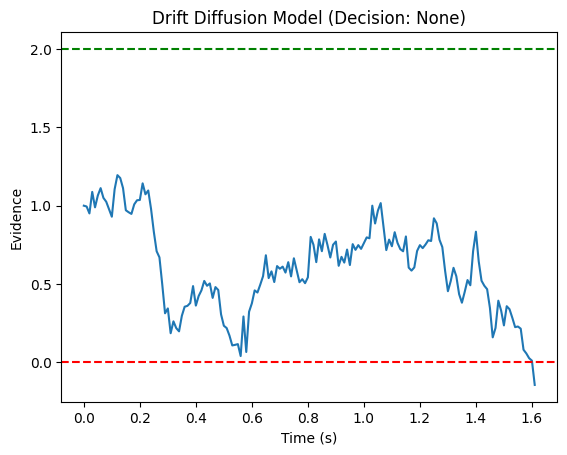

In [6]:
def run_ddm(drift_rate = 1,
            threshold = 1,
            starting_point = 0.5,
            noise_std = 1,
            non_decision_time = 0,
            dt = 0.01,
            max_time = 200):
    """
    Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

    Parameters are the same as the previous function.

    Arguments:
    - drift_rate: rate of evidence accumulation
    - threshold: evidence needed to reach a decision
    - starting_point: initial condition of the evidence
    - noise_std: standard deviation of the noise term
    - non_decision_time: time not included in the evidence accumulation process
    - dt: time increment
    - max_time: maximum simulation time

    Returns:
    - decision_time: the time taken to reach a decision
    - evidence_over_time: the evidence accumulated over time
    - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
    """
    # Initialize evidence accumulation process
    time = non_decision_time
    evidence = starting_point
    evidence_over_time = [evidence]

    # Run the simulation until a decision boundary is reached or max time is exceeded
    while time < max_time:
        # Increment the evidence by the drift and some noise
        evidence += drift_rate * dt + np.sqrt(dt) * noise_std * np.random.normal() # THERE IS A BUG IN THIS LINE
        evidence_over_time.append(evidence)
        time += dt  # Increment the time

        # Check if the evidence has reached either threshold
        if evidence >= threshold: # THERE IS A BUG IN THIS LINE
            return time, evidence_over_time, 1  # Decision made for the upper threshold
        elif evidence <= 0:
            return time, evidence_over_time, -1  # Decision made for the lower threshold

    # If no decision has been made by max_time, return the current state
    return time, evidence_over_time, 0

v = 0.01          # drift rate
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

# Run the simulation with the fixed function
decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                      threshold = a,
                                                      starting_point = z,
                                                      noise_std = sigma,
                                                      non_decision_time = t0,
                                                      dt = dt,
                                                      max_time = max_time)

# Plot the results with the correct matching of time and evidence points
plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
plt.axhline(y=a, color='green', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Evidence')
plt.title(f'Drift Diffusion Model (Decision: {"Upper" if decision == 1 else "Lower" if decision == 0 else "None"})')
plt.show()

In [9]:
varying_drift_model = hssm.HSSM(
    data=filtered_df,
    model="ddm",
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + task_transition"
        },
    ],
)

In [10]:
simulated_data_drift = varying_drift_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_task_transition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15655 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [11]:
varying_threshold_model = hssm.HSSM(
    data=filtered_df,
    include=[
        {
            "name": "a",
            "formula": "a ~ 1 + task_transition"
        }  
    ],
)

In [12]:
simulated_data_threshold = varying_threshold_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'z_interval__': array(0., dtype=float32), 'v': array(0., dtype=float32), 't_log__': array(-2.3025851, dtype=float32), 'a_Intercept': array(0., dtype=float32), 'a_task_transition': array(0., dtype=float32)}

Logp initial evaluation results:
{'z': -1.39, 'v': -1.61, 't': -3.22, 'a_Intercept': -2.17, 'a_task_transition': -2.53, 'rt,response': inf}
You can call `model.debug()` for more details.

In [13]:
varying_threshold_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1569

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)
a:
    Formula: a ~ 1 + task_transition
    Priors:
        a_Intercept ~ Normal(mu: 0.0, sigma: 3.5099000930786133)
        a_task_transition ~ Normal(mu: 0.0, sigma: 5.000500202178955)
    Link: identity
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: HalfNormal(sigma: 2.0, initval: 0.10000000149011612)
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)